<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/test/YUJIE-Hyperparameters%20Choosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install torch and torchvision

In [1]:
!pip install torch torchvision matplotlib


# install dataset CIFAR-100

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
from PIL import Image

# Data preprocessing
class Cutout(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        # 如果 img 是 PIL.Image，则先转换为 NumPy 数组
        if isinstance(img, Image.Image):
            img = np.array(img)

        h, w = img.shape[:2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.size // 2, 0, h)
        y2 = np.clip(y + self.size // 2, 0, h)
        x1 = np.clip(x - self.size // 2, 0, w)
        x2 = np.clip(x + self.size // 2, 0, w)
        mask[y1: y2, x1: x2] = 0
        img = img * mask[:, :, np.newaxis]  # Apply a mask to the RGB channel
        return Image.fromarray(np.uint8(img))

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    Cutout(size=8),  # Add Cutout
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-100 dataset
start_time = time.time()
train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

# Split training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,  # Updated batch size
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Enable prefetching
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Test data loading performance
data_start = time.time()
for i, (inputs, labels) in enumerate(train_loader):
    if i == 10:  # Test first 10 batches
        break
print(f"Data loading for 10 batches: {time.time() - data_start:.2f} seconds")


100%|██████████| 169M/169M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Dataset loading time: 7.19 seconds
Data loading for 10 batches: 1.99 seconds


# Hyperparameters choosing

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast


# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Define LeNet-5 model with dynamic dropout
class LeNet5(nn.Module):
    def __init__(self, dropout1=0.3, dropout2=0.3):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(512, 1024)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc3 = nn.Linear(1024, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Random search with dropout and patience
def random_search(train_loader, val_loader, model_class, device, num_trials=10):
    param_space = {
        'lr': [1e-4, 1e-3, 1e-2, 1e-1],
        'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
        'momentum': [0.9, 0.95],
        'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
        'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
        'patience': [2, 3, 5]
    }

    results = []

    for trial in range(num_trials):
        print(f"Trial {trial + 1}/{num_trials}")
        lr = random.choice(param_space['lr'])
        weight_decay = random.choice(param_space['weight_decay'])
        momentum = random.choice(param_space['momentum'])
        dropout1 = random.choice(param_space['dropout1'])
        dropout2 = random.choice(param_space['dropout2'])
        patience = random.choice(param_space['patience'])

        model = model_class(dropout1=dropout1, dropout2=dropout2).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        scheduler = CosineAnnealingLR(optimizer, T_max=5)
        criterion = nn.CrossEntropyLoss()
        early_stopping = EarlyStopping(patience=patience, verbose=True)

        train_loss, val_loss, val_acc = train_and_evaluate(
            model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=5, device=device, early_stopping=early_stopping
        )

        results.append({
            'lr': lr,
            'weight_decay': weight_decay,
            'momentum': momentum,
            'dropout1': dropout1,
            'dropout2': dropout2,
            'patience': patience,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    results.sort(key=lambda x: x['val_acc'], reverse=True)
    print("\nBest Hyperparameters:")
    print(results[0])

    return results[0]  # Return the best result


# Training and evaluation function with early stopping
def train_and_evaluate(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, device, early_stopping):
    model.train()
    scaler = GradScaler(device='cuda')  # Initialize mixed precision scaler

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training loop
        train_loss_total = 0
        train_correct, train_total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast(device_type='cuda'):  # Mixed precision forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss /= len(val_loader)

        epoch_end = time.time()
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        scheduler.step()

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping at epoch:", epoch + 1)
            break

    return train_loss, val_loss, val_acc


# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    best_hyperparams = random_search(
        train_loader=train_loader,
        val_loader=val_loader,
        model_class=LeNet5,
        device=device,
        num_trials=10
    )

    print("\nUsing Best Hyperparameters:")
    print(best_hyperparams)


Trial 1/10
Epoch 1/5 | Train Loss: 4.6057 | Train Acc: 0.95% | Val Loss: 4.6050 | Val Acc: 1.03%
Validation loss decreased (inf --> 4.605030).  Saving model ...
Epoch 2/5 | Train Loss: 4.6054 | Train Acc: 1.02% | Val Loss: 4.6049 | Val Acc: 1.12%
Validation loss decreased (4.605030 --> 4.604946).  Saving model ...
Epoch 3/5 | Train Loss: 4.6053 | Train Acc: 1.06% | Val Loss: 4.6050 | Val Acc: 1.05%
EarlyStopping counter: 1 out of 3
Epoch 4/5 | Train Loss: 4.6052 | Train Acc: 1.09% | Val Loss: 4.6047 | Val Acc: 1.13%
Validation loss decreased (4.604946 --> 4.604741).  Saving model ...
Epoch 5/5 | Train Loss: 4.6052 | Train Acc: 1.06% | Val Loss: 4.6048 | Val Acc: 1.09%
EarlyStopping counter: 1 out of 3
Trial 2/10
Epoch 1/5 | Train Loss: 4.6046 | Train Acc: 1.12% | Val Loss: 4.6027 | Val Acc: 1.20%
Validation loss decreased (inf --> 4.602703).  Saving model ...
Epoch 2/5 | Train Loss: 4.5992 | Train Acc: 1.46% | Val Loss: 4.5953 | Val Acc: 1.53%
Validation loss decreased (4.602703 --> 4.

# Centralized baseline


Using Best Hyperparameters: {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9, 'dropout1': 0.3, 'dropout2': 0.3, 'patience': 5}
Epoch 1/150 | Train Loss: 4.5734, Train Acc: 1.59% | Val Loss: 4.4688, Val Acc: 2.78%
Validation loss decreased (inf --> 4.468755). Saving model ...
Epoch 2/150 | Train Loss: 4.3022, Train Acc: 4.59% | Val Loss: 4.1180, Val Acc: 6.85%
Validation loss decreased (4.468755 --> 4.117968). Saving model ...
Epoch 3/150 | Train Loss: 4.1113, Train Acc: 6.71% | Val Loss: 4.0010, Val Acc: 8.87%
Validation loss decreased (4.117968 --> 4.001020). Saving model ...
Epoch 4/150 | Train Loss: 3.9975, Train Acc: 8.36% | Val Loss: 3.8845, Val Acc: 9.81%
Validation loss decreased (4.001020 --> 3.884511). Saving model ...
Epoch 5/150 | Train Loss: 3.8855, Train Acc: 10.29% | Val Loss: 3.7739, Val Acc: 11.99%
Validation loss decreased (3.884511 --> 3.773870). Saving model ...
Epoch 6/150 | Train Loss: 3.7745, Train Acc: 11.89% | Val Loss: 3.6853, Val Acc: 13.51%
Validation lo

<ipython-input-9-4b9d932bc4a8>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Final Test Accuracy: 49.16%


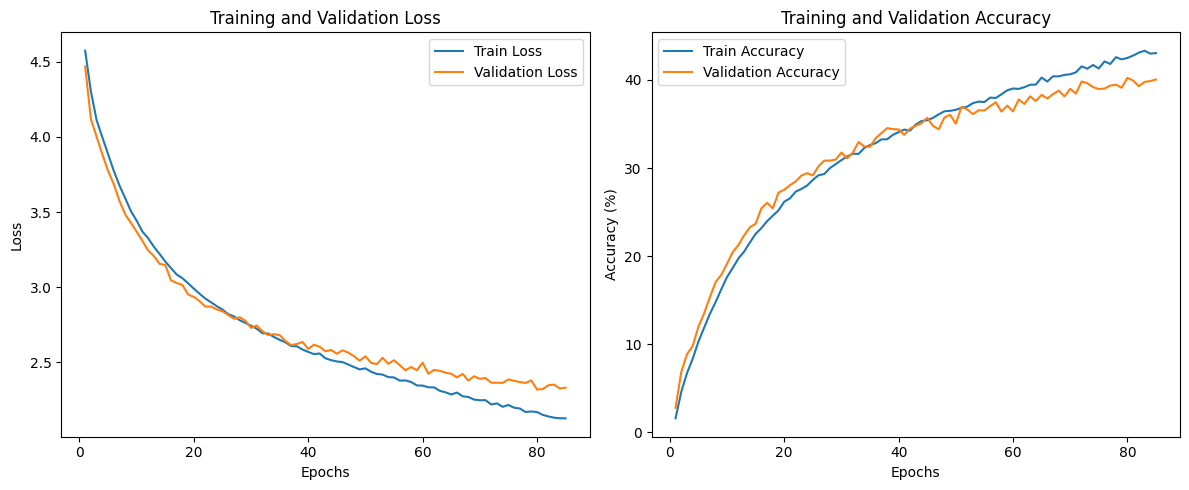

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, dropout1=0.3, dropout2=0.3):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(512, 1024)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc3 = nn.Linear(1024, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Centralized baseline training function
def train_model_with_hyperparams(train_loader, val_loader, test_loader, best_hyperparams, num_epochs, device):
    model = LeNet5(dropout1=best_hyperparams['dropout1'], dropout2=best_hyperparams['dropout2']).to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=best_hyperparams['lr'],
        momentum=best_hyperparams['momentum'],
        weight_decay=best_hyperparams['weight_decay']
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=best_hyperparams.get('patience', 5), verbose=True)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast(device_type=device.type):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(device_type=device.type):
                outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use the best hyperparameters from random search
    best_hyperparams = {
        'lr': 0.01,  # Replace with found hyperparameters
        'weight_decay': 0.0001,
        'momentum': 0.9,
        'dropout1': 0.3,
        'dropout2': 0.3,
        'patience': 5
    }

    print("\nUsing Best Hyperparameters:", best_hyperparams)

    # Train with the best hyperparameters
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        best_hyperparams=best_hyperparams,
        num_epochs=150,
        device=device
    )

    # Plot results
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# NEW OPTIMIZERS

In [ ]:
# Train with NEW optimizer in this module